In [1]:
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.analysis_tools import PackedSelection
import hist
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import numba
import uproot 
#plt.style.use(hep.style.CMS)

In [2]:
redirector = {"hdfs":"/hdfs",
              "local":"",
              "global":"root://cms-xrd-global.cern.ch//",
              "infn":"root://xrootd-cms.infn.it//",
              "fermilab":"root://cmsxrootd.fnal.gov//",
             }
file = "/store/mc/RunIIAutumn18NanoAODv7/MonoHTobb_ZpBaryonic_TuneCP2_13TeV_madgraph-pythia8/NANOAODSIM/Nano02Apr2020_rp_102X_upgrade2018_realistic_v21-v1/10000/0EE0D641-EDAE-D547-ABAD-56D54B768C5B.root"
local_file = "/home/prayag/Coffea/data/3BF5BC57-5D24-1C4D-B277-7B0BAA5DF3C7.root"
filename= redirector["local"] + local_file

In [3]:
events = NanoEventsFactory.from_root(
    filename,
    schemaclass = NanoAODSchema.v7,
    metadata = {"Dataset":"HiggsTobbbarZprimeBaryonic","isMC":True},
    #entry_stop=10e5 ,
).events()
print("Number of events loaded : ", len(events))

Number of events loaded :  297347


In [59]:
selection = PackedSelection()
selection.add("pt25", ak.all(events.Jet.pt > 25, axis=1))
cuts = selection.all("pt25")
good_events = events[cuts]

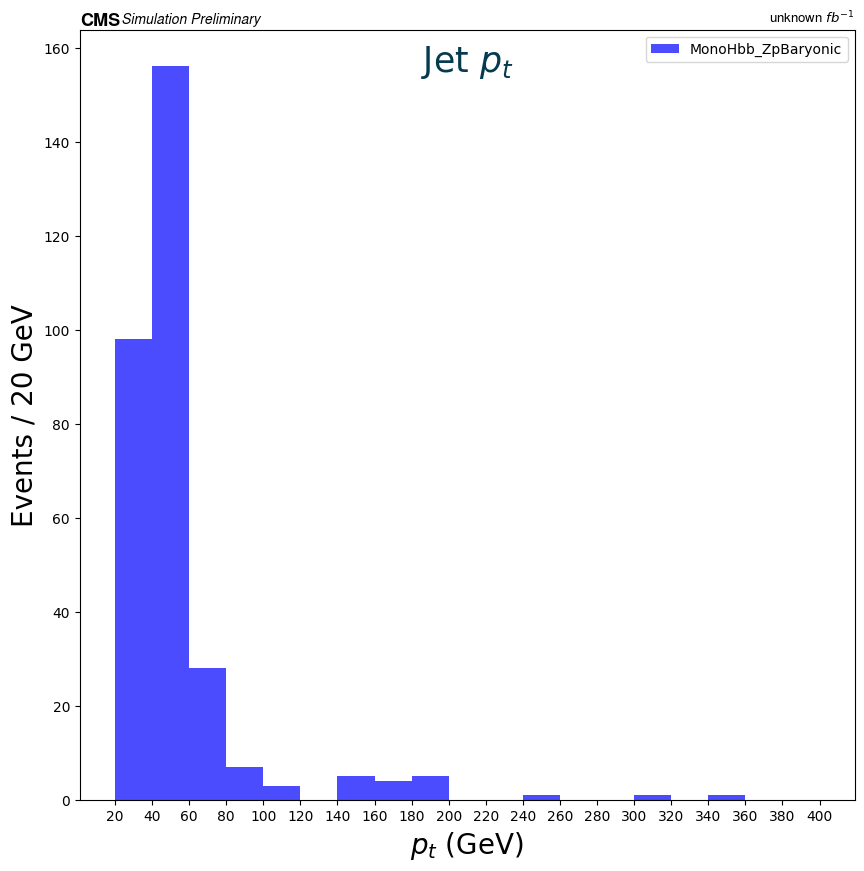

In [60]:
x_min = 20
x_max = 400
bin_size = 20
n_bins=int((x_max - x_min)/bin_size)
h = hist.Hist.new.Reg(n_bins,x_min,x_max).Double().fill(ak.flatten(good_events.Jet.pt))
fig , ax= plt.subplots(figsize=(10,10))
hep.histplot(h, 
             #bins=bins ,
             histtype="fill",
             color="b",
             alpha=0.7,
             edgecolor="black",
             label=r"MonoHbb_ZpBaryonic",
             ax=ax
            )
ax.set_title("Jet $p_t$", y=1.0, pad=-30, fontsize=25, color="#053B50")
ax.set_xlabel("$p_t$ (GeV)", fontsize=20)
ax.set_ylabel(f"Events / {bin_size} GeV", fontsize=20)
ax.set_xticks(np.arange(x_min,x_max+bin_size,bin_size))
hep.cms.label("Preliminary",data=False, rlabel="unknown $fb^{-1}$")
ax.legend()
#fig.savefig("Result.jpg",dpi=300)

In [61]:
Jets = events.Jet[events.Jet.pt > 25]
btag_WP_medium = 0.3040
ak4_BJets_med = Jets[ Jets.btagDeepFlavB > btag_WP_medium ]

In [62]:
ak4_BJets_med[ak.num(ak4_BJets_med)>2]

<JetArray [[Jet, Jet, Jet], ... Jet, Jet, Jet]] type='237 * var * jet'>

In [63]:
def ObtainDiJets(Jets, ak4_BJets_med):
    Jets = Jets[ak.num(Jets)>1]
    DiJets = Jets[:,0]+Jets[:,1]
    ak4_BJets_med = ak4_BJets_med[ak.num(ak4_BJets_med)>2]
    DiJets_bb = ak4_BJets_med[:,0]+ak4_BJets_med[:1]
    return DiJets , DiJets_bb

In [64]:
DiJets , DiJets_bb = ObtainDiJets(Jets, ak4_BJets_med)
DiJets.mass

<Array [83.4, 227, 673, 106, ... 151, 528, 81] type='189400 * float32'>

In [65]:
import json
with open("Kinematics/fileset.json") as f:
    files = json.load(f)
print(files["MC"])

{'MonoHbbZpBaryonic': ['root://cmsxrootd.fnal.gov///store/mc/RunIIAutumn18NanoAODv7/MonoHTobb_ZpBaryonic_TuneCP2_13TeV_madgraph-pythia8/NANOAODSIM/Nano02Apr2020_rp_102X_upgrade2018_realistic_v21-v1/00000/1171A356-937B-D346-B31E-D7397CD17A9E.root', 'root://cmsxrootd.fnal.gov///store/mc/RunIIAutumn18NanoAODv7/MonoHTobb_ZpBaryonic_TuneCP2_13TeV_madgraph-pythia8/NANOAODSIM/Nano02Apr2020_rp_102X_upgrade2018_realistic_v21-v1/00000/B92C3E7A-425A-2A40-812C-F733C1287C79.root', 'root://cmsxrootd.fnal.gov///store/mc/RunIIAutumn18NanoAODv7/MonoHTobb_ZpBaryonic_TuneCP2_13TeV_madgraph-pythia8/NANOAODSIM/Nano02Apr2020_rp_102X_upgrade2018_realistic_v21-v1/00000/D53C3745-8D33-D34A-8FA2-2B42E1AB5FB4.root', 'root://cmsxrootd.fnal.gov///store/mc/RunIIAutumn18NanoAODv7/MonoHTobb_ZpBaryonic_TuneCP2_13TeV_madgraph-pythia8/NANOAODSIM/Nano02Apr2020_rp_102X_upgrade2018_realistic_v21-v1/10000/0EE0D641-EDAE-D547-ABAD-56D54B768C5B.root', 'root://cmsxrootd.fnal.gov///store/mc/RunIIAutumn18NanoAODv7/MonoHTobb_ZpBary

In [66]:
JetHist= (
            hist.Hist.new.StrCat(["Untagged","btagDeepFlavB"], name="Type")
            .Reg(50,0.,500., name="pt", label="$p_t$ (GeV)")
            .Double()
            )
JetHist.fill(Type="Untagged", pt = ak.flatten(Jets.pt))
JetHist.fill(Type="btagDeepFlavB", pt = ak.flatten(ak4_BJets_med.pt))
Jetpt_Hist = JetHist

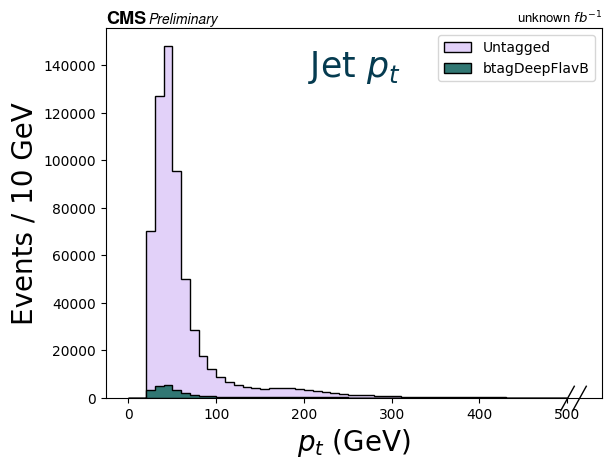

In [67]:
x_min = 0.
x_max = 500.
bin_size = 10
n_bins=int((x_max - x_min)/bin_size)
#bins = 
#fig , ax= plt.subplots(figsize=(10,10))
fig , ax = plt.subplots()
hep.histplot([ Jetpt_Hist["Untagged",:], Jetpt_Hist["btagDeepFlavB",:] ], 
             #stack=True ,
             #bins=bins ,
             histtype="fill",
             color=[ "#E2D1F9", "#317773" ],
             edgecolor="black",
             label=[ r"Untagged" , r"btagDeepFlavB"],
             lw=1,
             #density=True,
             #binticks=True ,
             ax=ax ,
             
            )
# hep.histplot(Jetpt_Hist["btagDeepFlavB",:], 
#              #bins=bins ,
#              histtype="fill",
#              color="r",
#              alpha=0.7,
#              edgecolor="black",
#              label=r"btagDeepFlavB",
#              ax=ax ,
#              stack=True
#             )
ax.set_title("Jet $p_t$", y=1.0, pad = -35 , fontsize=25, color="#053B50")
ax.set_xlabel("$p_t$ (GeV)", fontsize=20)
ax.set_ylabel(f"Events / {bin_size} GeV", fontsize=20)
ax.set_xticks(np.arange(x_min,x_max+bin_size,bin_size*10))
hep.cms.label("Preliminary",data = "Data", rlabel="unknown $fb^{-1}$")
ax.legend()

Text(0.5, 1.0, '2D Histogram')

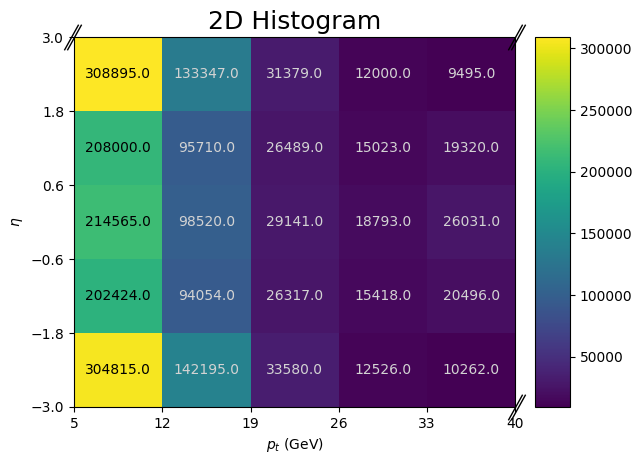

In [68]:
# Make a 2d histogram

eta_hist = hist.axis.Regular(5,-3,3, name= "eta", label="$\eta$")
pt_hist = hist.axis.Regular(5,5,40, name="pt", label="$p_t$ (GeV)")
twoDhist= hist.Hist(pt_hist , eta_hist )
twoDhist.fill(eta = ak.flatten(events.Jet.eta) , pt = ak.flatten(events.Jet.pt)) 
fig , ax = plt.subplots()
hep.hist2dplot(twoDhist, labels=True, ax=ax)
ax.set_title("2D Histogram" , size = 18)

`ak.broadcast_arrays` : This function returns the input arrays with enough elements duplicated that they can be combined element-by-element.

In [69]:
a = ak.Array([1,2,[3 ,4 ]])
print("a= ", a)
b = ak.Array([[5,2,],6,7])
print("b= ", b)
c = ak.broadcast_arrays(a,b)
print("c= ", c)

a=  [1, 2, [3, 4]]
b=  [[5, 2], 6, 7]
c=  [<Array [[1, 1], 2, [3, 4]] type='3 * union[var * int64, int64]'>, <Array [[5, 2], 6, [7, 7]] type='3 * union[var * int64, int64]'>]


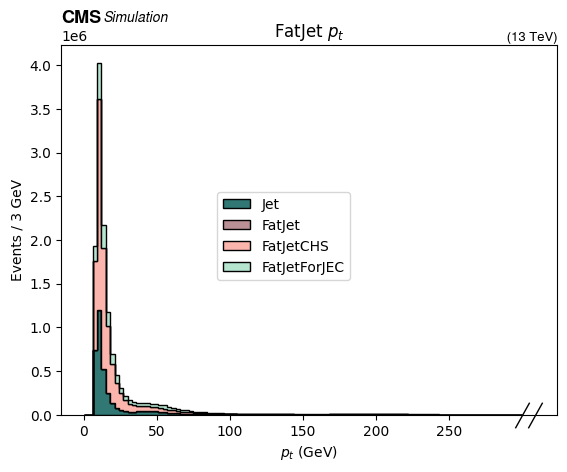

In [112]:
fatjet_hist = (
    hist.Hist.new
    .StrCat(["Jet","FatJet","FatJetCHS","FatJetForJEC"], name="jet", label="Jets")
    .Regular(100,0,300,name="pt")
    .Double()
    )
fatjet_hist.fill(jet="Jet", pt= ak.flatten(events.Jet.pt) )
fatjet_hist.fill(jet="FatJet", pt= ak.flatten(events.FatJet.pt) )
fatjet_hist.fill(jet="FatJetCHS", pt= ak.flatten(events.FatJetCHS.pt) )
fatjet_hist.fill(jet="FatJetForJEC", pt= ak.flatten(events.FatJetForJEC.pt) )
hists= [ fatjet_hist["Jet", :], fatjet_hist["FatJet", :] ,fatjet_hist["FatJetCHS", :], fatjet_hist["FatJetForJEC", :] ]
fig , ax = plt.subplots()
fill_colors = ["#317773" , "#B99095", "#FCB5AC", "#B5E5CF"]
labels =["Jet","FatJet","FatJetCHS","FatJetForJEC"]
hep.histplot(
    hists ,
    histtype="fill",
    color = fill_colors,
    edgecolor="black",
    label=labels,
    stack=True ,
    lw=1,
    ax=ax
)
ax.set_title("FatJet $p_t$")
hep.cms.label("", pad=0.05)
fig.legend(loc = 10)
ax.set_xlabel("$p_t$ (GeV)")
ax.set_ylabel("Events / 3 GeV")
ax.set_xticks(np.arange(0,300,50))

In [2]:
from coffea import util

In [4]:
data = util.load("Kinematics/Datakinematics.coffea")

In [5]:
data["Histograms"]["Tag"]

Hist(Regular(20, 0, 1, label='Axis 0'), storage=Double()) # Sum: 106075.0

In [1]:
import os

In [4]:
"Datakinematics.coffea" in os.listdir("Kinematics")

True

In [26]:
events.MET.fields

['MetUnclustEnUpDeltaX',
 'MetUnclustEnUpDeltaY',
 'covXX',
 'covXY',
 'covYY',
 'phi',
 'pt',
 'significance',
 'sumEt',
 'sumPtUnclustered']

In [10]:
events.Flag.fields

['HBHENoiseFilter',
 'HBHENoiseIsoFilter',
 'CSCTightHaloFilter',
 'CSCTightHaloTrkMuUnvetoFilter',
 'CSCTightHalo2015Filter',
 'globalTightHalo2016Filter',
 'globalSuperTightHalo2016Filter',
 'HcalStripHaloFilter',
 'hcalLaserEventFilter',
 'EcalDeadCellTriggerPrimitiveFilter',
 'EcalDeadCellBoundaryEnergyFilter',
 'ecalBadCalibFilter',
 'goodVertices',
 'eeBadScFilter',
 'ecalLaserCorrFilter',
 'trkPOGFilters',
 'chargedHadronTrackResolutionFilter',
 'muonBadTrackFilter',
 'BadChargedCandidateFilter',
 'BadPFMuonFilter',
 'BadPFMuonDzFilter',
 'hfNoisyHitsFilter',
 'BadChargedCandidateSummer16Filter',
 'BadPFMuonSummer16Filter',
 'trkPOG_manystripclus53X',
 'trkPOG_toomanystripclus53X',
 'trkPOG_logErrorTooManyClusters',
 'METFilters',
 'HBHENoiseFilter_pRECO',
 'HBHENoiseIsoFilter_pRECO',
 'CSCTightHaloFilter_pRECO',
 'CSCTightHaloTrkMuUnvetoFilter_pRECO',
 'CSCTightHalo2015Filter_pRECO',
 'globalTightHalo2016Filter_pRECO',
 'globalSuperTightHalo2016Filter_pRECO',
 'HcalStripHaloFil

In [29]:
events.Flag.METFilters.__doc__

'Trigger/flag bit (process: PAT)'

In [71]:
METhist = (
    hist.
    Hist.
    new.
    StrCat(["noflags","flags"], name="type").
    Reg(100,0,500, name="pt", label="$p_t$ (GeV)")
    .Double()
    )

In [72]:
METflags = PackedSelection()
METflags.add("goodVertices", events.Flag.goodVertices)
METflags.add("tightHalo", events.Flag.globalTightHalo2016Filter)
METflags.add("hbheNoise", events.Flag.HBHENoiseFilter)
METflags.add("hbheNoiseIso", events.Flag.HBHENoiseIsoFilter)
METflags.add("eebadSC", events.Flag.eeBadScFilter)
METflags.add("EcalDeadcell", events.Flag.EcalDeadCellTriggerPrimitiveFilter)
METflags.add("badPFmuon", events.Flag.BadPFMuonFilter )
METflags.add("Ecalbadcalib",events.Flag.ecalBadCalibFilter )

flags = METflags.all(
    "goodVertices",
    "tightHalo",
    "hbheNoise",
    "hbheNoiseIso",
    "eebadSC",
    "EcalDeadcell",
    "badPFmuon",
    "Ecalbadcalib"
    )

MET = events.MET[flags]

In [73]:
METhist.fill(type="noflags", pt= events.MET.pt)
METhist.fill(type="flags", pt=  MET.pt)

Hist(
  StrCategory(['noflags', 'flags'], name='type'),
  Regular(100, 0, 500, name='pt', label='$p_t$ (GeV)'),
  storage=Double()) # Sum: 593118.0 (593124.0 with flow)

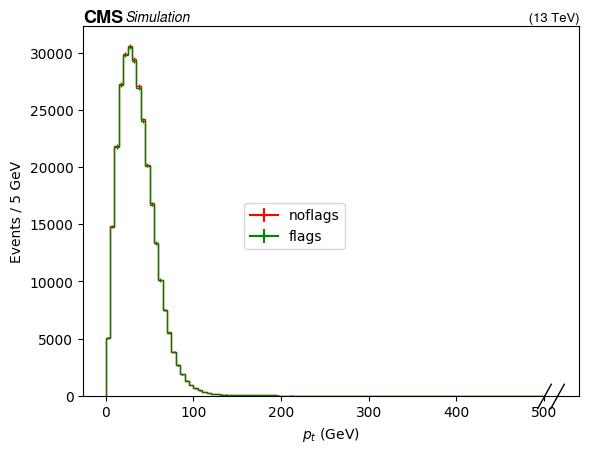

In [74]:
fig, ax = plt.subplots()
hep.histplot(
    [METhist["noflags",:],METhist["flags",:] ],
    color=["red","green"],
    label=["noflags","flags"],
    lw=1,
    ax=ax
)
hep.cms.label("")
ax.set_ylabel("Events / 5 GeV")
fig.legend(loc=10)

In [78]:
from coffea import util
ya = util.load("Kinematics/DataMETstudy.coffea")
ya["Histograms"]["MET"]

Hist(
  StrCategory(['noflags', 'flags'], name='type'),
  Regular(100, 0, 500, name='pt', label='$p_t$ (GeV)'),
  storage=Double()) # Sum: 89873.0 (90189.0 with flow)

In [25]:
delta = 0.007
hist.Hist.new.Reg(100,0,100).Double().fill(events.MET.eta).plot()

AttributeError: no field named 'eta'

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.3/src/awkward/highlevel.py#L1124)